[✓] Flow CSV: d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\inputs\SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv
[✓] Sensor meta: d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\inputs\sensor-location.xlsx
[✓] TomTom CSV (raw): d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\data\TomTom_data_20-24Aug2025.csv
[✓] Vessel CSV (raw): d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\data\Vesselposition_data_20-24Aug2025.csv
[✓] TomTom parquet (cache): d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\data\_cache\tomtom_quick.parquet
[✓] Vessel parquet (cache): d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\data\_cache\vessel_quick.parquet
[✓] NWB shapefile: d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\data\NWB_roads\w

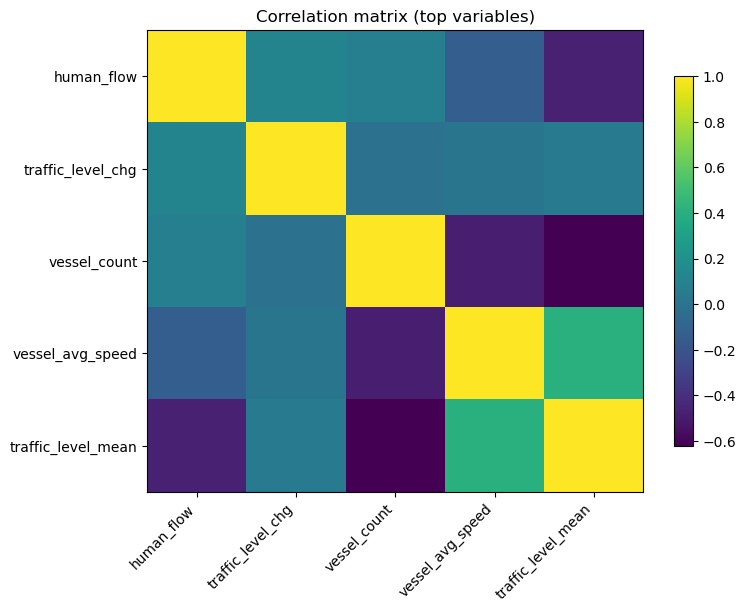

[Saved] d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\outputs\leadlag_traffic_level_mean.png


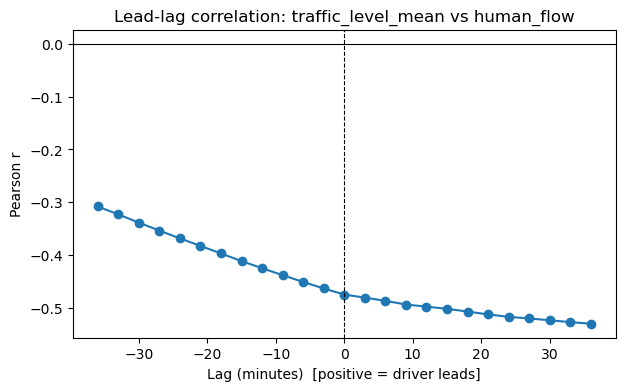

[Saved] d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\outputs\leadlag_traffic_level_chg.png


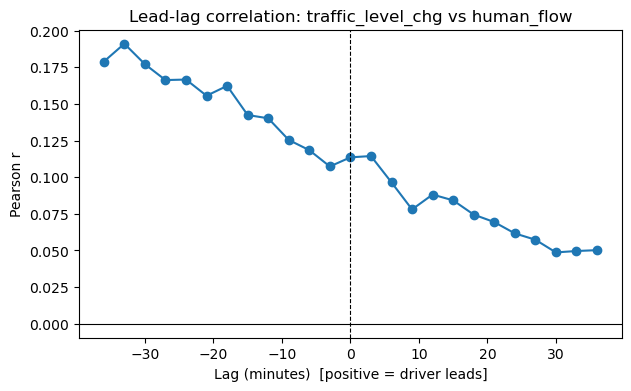

[Saved] d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\outputs\leadlag_vessel_count.png


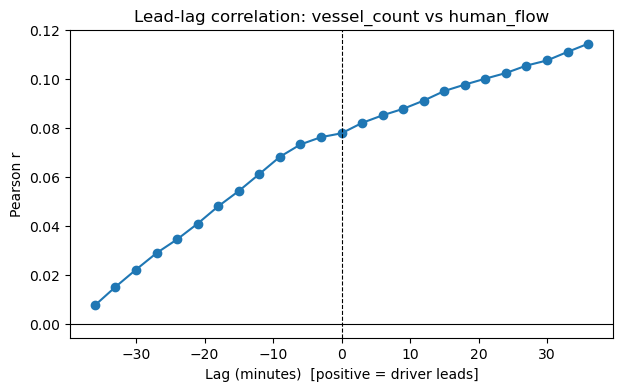

[Saved] d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\outputs\leadlag_vessel_avg_speed.png


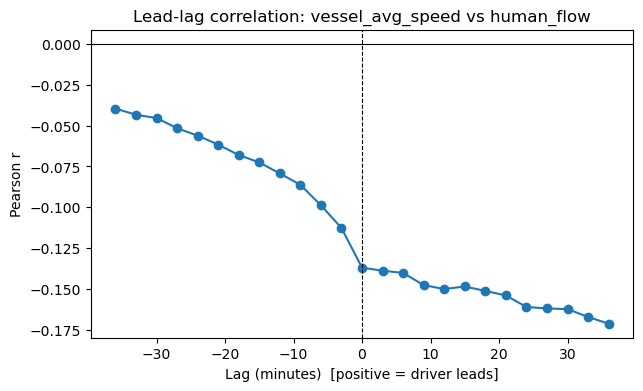

[Saved] d:\work\TUD\学期间\TIL6022 TIL Python Programming\Project\sail_crowd_dashboard_hardcoded\outputs\timeseries_small_multiples.png


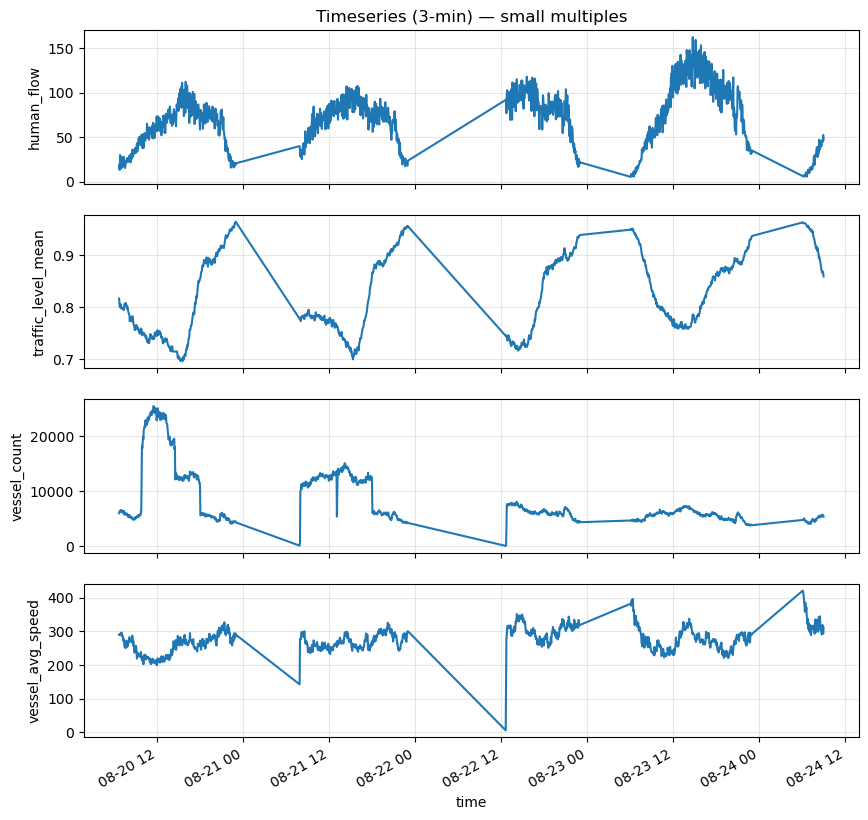

In [ ]:
# -*- coding: utf-8 -*-
"""
Exploratory correlation & lead-lag analysis for SAIL:
- Reads pedestrian flow (sensor CSV), TomTom (parquet if available, else CSV),
  Vessel (parquet if available, else CSV)
- Aligns to common frequency (default 3min)
- Builds driver series (traffic_level_mean, vessel_count, vessel_avg_speed, length, beam, per-type counts)
- Computes simple correlations vs flow and lead-lag correlations
- Saves summary tables and shows matplotlib plots

Author: team SAIL (Yuxuan + teammates)
"""

# ----------------------------- Imports -----------------------------
import os
import io
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from datetime import datetime

# ----------------------------- Config ------------------------------
# Project root = folder that contains this file (script) or current working dir (notebook)
try:
    ROOT = Path(__file__).resolve().parent
except NameError:
    # running in Jupyter/IPython where __file__ is undefined
    ROOT = Path.cwd()

# Data paths (relative)
FLOW_CSV    = ROOT / "inputs" / "SAIL2025_LVMA_data_3min_20August-25August2025_flow.csv"
SENSOR_XLSX = ROOT / "inputs" / "sensor-location.xlsx"   # (not used here but checked)

DATA_DIR    = ROOT / "data"
TT_CSV      = DATA_DIR / "TomTom_data_20-24Aug2025.csv"
VESSEL_CSV  = DATA_DIR / "Vesselposition_data_20-24Aug2025.csv"
NWB_SHP     = DATA_DIR / "NWB_roads" / "wegen_in_out.shp"  # optional, not used here

CACHE_DIR   = DATA_DIR / "_cache"
TT_PARQ     = CACHE_DIR / "tomtom_quick.parquet"
VES_PARQ    = CACHE_DIR / "vessel_quick.parquet"
# Fallback names if teammates saved in data/ instead of _cache/
TT_PARQ_FALLBACK  = DATA_DIR / "tt_minute.parquet"
VES_PARQ_FALLBACK = DATA_DIR / "vessel_minute.parquet"

OUT_DIR     = ROOT / "outputs"

# Ensure folders
OUT_DIR.mkdir(parents=True, exist_ok=True)
CACHE_DIR.mkdir(parents=True, exist_ok=True)

# Quick sanity check
def _check(p: Path, label: str):
    print(f"[{'✓' if p.exists() else '✗'}] {label}: {p}")

_check(FLOW_CSV,  "Flow CSV")
_check(SENSOR_XLSX,"Sensor meta")
_check(TT_CSV,    "TomTom CSV (raw)")
_check(VESSEL_CSV,"Vessel CSV (raw)")
_check(TT_PARQ,   "TomTom parquet (cache)")
_check(VES_PARQ,  "Vessel parquet (cache)")
_check(NWB_SHP,   "NWB shapefile")

# --- Analysis parameters ---
FREQ = "3min"             # unified resample freq
USE_PARQUET_FIRST = True  # prefer parquet if exists
READ_SAMPLE_ROWS  = 200000  # when reading huge CSVs for EDA
TIMEZONE_NAIVE    = True   # drop tz
PLOT_SHOW         = True
SAVE_PNG          = True

# Choose a sensor or None for city-wide mean
SENSOR_BASE = None
# Lead-lag window
LAG_STEPS = 12  # +/- 36 minutes for 3min freq

# ------------------------- Helper functions ------------------------
def to_naive_ts(s: pd.Series) -> pd.Series:
    """Parse to datetime, localize to UTC then drop tz -> tz-naive."""
    s = pd.to_datetime(s, errors="coerce", utc=True)
    return s.dt.tz_convert(None) if TIMEZONE_NAIVE else s

def ensure_naive_index(df_or_s):
    """Ensure DatetimeIndex is tz-naive (for joining)."""
    if isinstance(df_or_s, pd.Series):
        obj = df_or_s
        idx = obj.index
        if isinstance(idx, pd.DatetimeIndex) and idx.tz is not None:
            obj.index = idx.tz_convert(None)
        return obj
    else:
        df = df_or_s
        idx = df.index
        if isinstance(idx, pd.DatetimeIndex) and idx.tz is not None:
            df.index = idx.tz_convert(None)
        return df

def safe_read_csv(path: Path, **kwargs):
    if not path.exists():
        raise FileNotFoundError(f"File not found: {path}")
    return pd.read_csv(path, **kwargs)

def parse_flow_wide_to_long(flow_df: pd.DataFrame) -> pd.DataFrame:
    """
    Flow wide CSV -> long: [timestamp, sensor_base, flow]
    - sensor_base = remove trailing _<angle> suffix
    - flow = sum across angles per sensor_base per timestamp
    """
    ts_col = next((c for c in flow_df.columns if c.lower() == "timestamp"), flow_df.columns[0])
    df = flow_df.copy()
    df[ts_col] = to_naive_ts(df[ts_col])  # <— 保证无时区
    value_cols = [c for c in df.columns if c != ts_col]
    long = df.melt(id_vars=[ts_col], value_vars=value_cols,
                   var_name="sensor_angle", value_name="count")
    long["sensor_base"] = long["sensor_angle"].str.replace(r"_[0-9]+$", "", regex=True)
    long["count"] = pd.to_numeric(long["count"], errors="coerce")
    agg = (long.groupby([ts_col, "sensor_base"])["count"].sum()
                 .reset_index()
                 .rename(columns={ts_col: "timestamp", "count": "flow"}))
    return agg.sort_values(["sensor_base", "timestamp"])

def get_flow_series(flow_long: pd.DataFrame, sensor_base: str|None, freq: str) -> pd.Series:
    if sensor_base:
        s = (flow_long[flow_long["sensor_base"] == sensor_base]
             .set_index("timestamp")["flow"].sort_index().resample(freq).mean())
    else:
        s = (flow_long.set_index("timestamp")
             .groupby("timestamp")["flow"].mean().sort_index().resample(freq).mean())
    s = ensure_naive_index(s)  # <— 保证索引无时区
    s.name = "human_flow"
    return s

def read_tomtom_nested_csv(path: Path, nrows: int|None = None, chunksize: int = 50_000) -> pd.DataFrame:
    """
    TomTom CSV with columns [time, data] where 'data' is a micro-CSV: "id,traffic_level\\n..."
    -> long table: [timestamp, road_id, traffic_level]
    """
    usecols = ["time", "data"]
    frames, rows_read = [], 0
    for chunk in pd.read_csv(path, usecols=usecols, chunksize=chunksize):
        if nrows is not None and rows_read >= nrows:
            break
        if nrows is not None:
            take = max(0, nrows - rows_read)
            chunk = chunk.iloc[:take]
        rows_read += len(chunk)

        chunk["time"] = to_naive_ts(chunk["time"])
        smalls = []
        for t, txt in zip(chunk["time"], chunk["data"].fillna("")):
            if not txt:
                continue
            try:
                body = txt.split("\n", 1)[1] if "\n" in txt else txt
                arr = np.fromstring(body.replace("\n", ","), sep=",")
                if arr.size < 2:
                    continue
                ids  = arr[0::2]
                vals = arr[1::2]
                df_small = pd.DataFrame({
                    "road_id": ids.astype(np.int64, copy=False),
                    "traffic_level": vals.astype(np.float32, copy=False)
                })
                df_small["timestamp"] = t
                smalls.append(df_small)
            except Exception:
                try:
                    small = pd.read_csv(io.StringIO(txt))
                    small.columns = [c.strip().lower() for c in small.columns]
                    if {"id", "traffic_level"}.issubset(small.columns):
                        small = small.rename(columns={"id": "road_id"})
                        small["timestamp"] = t
                        small["traffic_level"] = pd.to_numeric(small["traffic_level"], errors="coerce")
                        smalls.append(small[["timestamp", "road_id", "traffic_level"]])
                except Exception:
                    continue
        if smalls:
            frames.append(pd.concat(smalls, ignore_index=True))

    if not frames:
        return pd.DataFrame(columns=["timestamp", "road_id", "traffic_level"])
    out = pd.concat(frames, ignore_index=True)
    out["timestamp"] = to_naive_ts(out["timestamp"])  # <— 保证无时区
    out["road_id"] = out["road_id"].astype(str)
    return out[["timestamp", "road_id", "traffic_level"]]

def build_tomtom_drivers(tt_long: pd.DataFrame, freq: str) -> pd.DataFrame:
    if tt_long.empty:
        return pd.DataFrame(columns=["timestamp","traffic_level_mean","traffic_level_var","traffic_level_chg"])
    g = (tt_long.groupby("timestamp")["traffic_level"]
                 .agg(['mean', 'var'])
                 .rename(columns={'mean':'traffic_level_mean','var':'traffic_level_var'})
                 .sort_index())
    g.index = pd.to_datetime(g.index)  # 确保为 DatetimeIndex
    g = ensure_naive_index(g)          # <— 去时区
    g["traffic_level_chg"] = g["traffic_level_mean"].diff()
    return g.resample(freq).mean().reset_index()

def read_vessel_raw(csv_path: Path, nrows: int|None = None) -> pd.DataFrame:
    head = pd.read_csv(csv_path, nrows=0)
    cols = head.columns.tolist()
    want = [c for c in [
        "update-time","upload-timestamp","lat","lon",
        "speed-in-centimeters-per-second","short-term-avg-speed-in-cm-per-sec",
        "length","beam","type","sub-category"
    ] if c in cols]
    df = pd.read_csv(csv_path, usecols=want, nrows=nrows)
    ts_col = "update-time" if "update-time" in df.columns else "upload-timestamp"
    df["timestamp"] = to_naive_ts(df[ts_col])  # <— 保证无时区
    df = df.rename(columns={
        "speed-in-centimeters-per-second":"speed_cmps",
        "short-term-avg-speed-in-cm-per-sec":"speed_cmps_short"
    })
    return df

def build_vessel_drivers(df: pd.DataFrame, freq: str, top_k_types: int = 5) -> pd.DataFrame:
    if df.empty:
        return pd.DataFrame(columns=["timestamp","vessel_count"])
    g = df.set_index("timestamp").sort_index()
    g = ensure_naive_index(g)  # <— 保证索引无时区

    out = pd.DataFrame(index=pd.date_range(g.index.min(), g.index.max(), freq=freq))
    out.index.name = "timestamp"

    out["vessel_count"] = (g["lat"].resample(freq).count()
                           if "lat" in g.columns else g.resample(freq).size())
    if "speed_cmps" in g.columns:
        out["vessel_avg_speed"] = g["speed_cmps"].resample(freq).mean()
    elif "speed_cmps_short" in g.columns:
        out["vessel_avg_speed"] = g["speed_cmps_short"].resample(freq).mean()
    if "length" in g.columns:
        out["vessel_avg_length"] = g["length"].resample(freq).mean()
    if "beam" in g.columns:
        out["vessel_avg_beam"] = g["beam"].resample(freq).mean()

    if "type" in g.columns:
        type_counts = g["type"].value_counts().head(top_k_types).index.tolist()
        for tname in type_counts:
            ser = (g["type"].eq(tname).astype(int)).resample(freq).sum()
            out[f"type_count__{str(tname).strip().replace(' ','_')}"] = ser

    return out.reset_index()

def align_on_timestamp(series_list, how="inner"):
    """
    Align multiple Series/DataFrames on 'timestamp' (inner join) with tz-naive safety.
    """
    base = None
    for obj in series_list:
        if obj is None:
            continue
        df = obj.to_frame() if isinstance(obj, pd.Series) else obj.copy()
        if "timestamp" not in df.columns:
            df = df.reset_index()
        # force timestamps tz-naive
        df["timestamp"] = to_naive_ts(df["timestamp"])
        df = df.set_index("timestamp").sort_index()
        df = ensure_naive_index(df)
        base = df if base is None else base.join(df, how=how)
    base = ensure_naive_index(base)
    return base.reset_index()

def corr_table_vs_flow(df: pd.DataFrame, flow_col="human_flow") -> pd.DataFrame:
    if flow_col not in df.columns:
        return pd.DataFrame()
    y, corr = df[flow_col], {}
    for c in df.columns:
        if c in ("timestamp", flow_col):
            continue
        if pd.api.types.is_numeric_dtype(df[c]):
            corr[c] = y.corr(df[c])
    out = pd.Series(corr).sort_values(ascending=False).to_frame("pearson_r")
    out.index.name = "variable"
    return out

def lead_lag_corr(df: pd.DataFrame, x_col: str, y_col: str, max_lag_steps: int, freq_minutes: int) -> pd.DataFrame:
    res, x, y = [], df[x_col], df[y_col]
    for k in range(-max_lag_steps, max_lag_steps + 1):
        r = (y.corr(x.shift(k)) if k >= 0 else y.shift(-k).corr(x))
        res.append({"lag_steps": k, "lag_minutes": k * freq_minutes, "r": r})
    return pd.DataFrame(res)

def save_png(fig, name: str):
    if SAVE_PNG:
        path = OUT_DIR / name
        fig.savefig(path, dpi=150, bbox_inches="tight")
        print(f"[Saved] {path}")

# ----------------------------- Main --------------------------------
if __name__ == "__main__":
    t0 = time.time()
    print(f"Start EDA at {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

    # 1) Flow -> long -> series
    print("Reading FLOW CSV …")
    flow_wide = safe_read_csv(FLOW_CSV)
    flow_long = parse_flow_wide_to_long(flow_wide)
    flow_series = get_flow_series(flow_long, SENSOR_BASE, FREQ)

    # 2) TomTom drivers (parquet preferred; fallback to CSV)
    tt_parq_path = TT_PARQ if TT_PARQ.exists() else TT_PARQ_FALLBACK
    if USE_PARQUET_FIRST and tt_parq_path.exists():
        print(f"Loading TomTom from parquet … ({tt_parq_path.name})")
        tt_quick = pd.read_parquet(tt_parq_path)
        tt_quick["timestamp"] = to_naive_ts(tt_quick["timestamp"])  # <— 修复：去时区
        tt_drv = (tt_quick.sort_values("timestamp")
                           .set_index("timestamp")
                           .resample(FREQ).mean()
                           .pipe(ensure_naive_index)
                           .reset_index())
        if "traffic_level_var" not in tt_drv.columns:
            tt_drv["traffic_level_var"] = np.nan
        if "traffic_level_chg" not in tt_drv.columns and "traffic_level_mean" in tt_drv.columns:
            tt_drv["traffic_level_chg"] = tt_drv["traffic_level_mean"].diff()
    else:
        print("Parsing TomTom CSV (sample) …")
        tt_long = read_tomtom_nested_csv(TT_CSV, nrows=READ_SAMPLE_ROWS, chunksize=50_000)
        tt_drv  = build_tomtom_drivers(tt_long, FREQ)

    # 3) Vessel drivers (parquet preferred; fallback to CSV)
    ves_parq_path = VES_PARQ if VES_PARQ.exists() else VES_PARQ_FALLBACK
    if USE_PARQUET_FIRST and ves_parq_path.exists():
        print(f"Loading Vessel from parquet … ({ves_parq_path.name})")
        ves_quick = pd.read_parquet(ves_parq_path)
        ves_quick["timestamp"] = to_naive_ts(ves_quick["timestamp"])  # <— 修复：去时区
        ves_drv = (ves_quick.sort_values("timestamp")
                           .set_index("timestamp")
                           .resample(FREQ).mean()
                           .pipe(ensure_naive_index)
                           .reset_index())
        for col in ["vessel_avg_length", "vessel_avg_beam"]:
            if col not in ves_drv.columns:
                ves_drv[col] = np.nan
    else:
        print("Reading Vessel CSV (sample) …")
        ves_raw = read_vessel_raw(VESSEL_CSV, nrows=READ_SAMPLE_ROWS)
        ves_drv = build_vessel_drivers(ves_raw, FREQ, top_k_types=5)

    # 4) Align & clean
    merged = align_on_timestamp([flow_series, tt_drv, ves_drv], how="inner").dropna(how="all", axis=1)
    keep = ["timestamp","human_flow"] + [
        c for c in merged.columns
        if c not in ["timestamp","human_flow"] and pd.api.types.is_numeric_dtype(merged[c])
    ]
    merged = merged[keep].dropna()
    print(f"Merged shape: {merged.shape}")
    merged.to_csv(OUT_DIR / "merged_for_corr.csv", index=False)

    # 5) Pearson corr vs flow
    table_corr = corr_table_vs_flow(merged, flow_col="human_flow")
    print("\n=== Pearson corr vs human_flow ===")
    print(table_corr.head(20))
    table_corr.to_csv(OUT_DIR / "corr_vs_flow.csv")

    # 6) Lead-lag corr
    freq_minutes = int(pd.to_timedelta(FREQ).total_seconds() // 60)
    drivers_for_lag = [c for c in merged.columns if c not in ["timestamp","human_flow"]][:6]
    all_lag_rows = []
    for col in drivers_for_lag:
        lagdf = lead_lag_corr(merged.set_index("timestamp"),
                              x_col=col, y_col="human_flow",
                              max_lag_steps=LAG_STEPS, freq_minutes=freq_minutes)
        lagdf["variable"] = col
        all_lag_rows.append(lagdf)
    if all_lag_rows:
        lag_res = pd.concat(all_lag_rows, ignore_index=True)
        lag_res.to_csv(OUT_DIR / "lead_lag_corr.csv", index=False)
        print("\nSaved lead_lag_corr.csv")

    # 7) Plots
    if not table_corr.empty:
        top_vars = table_corr.index.tolist()[:6]
        corr_mat = merged[["human_flow"] + top_vars].corr()
        fig, ax = plt.subplots(figsize=(8, 6))
        im = ax.imshow(corr_mat.values, aspect="auto")
        ax.set_xticks(range(corr_mat.shape[1])); ax.set_xticklabels(corr_mat.columns, rotation=45, ha='right')
        ax.set_yticks(range(corr_mat.shape[0])); ax.set_yticklabels(corr_mat.index)
        ax.set_title("Correlation matrix (top variables)")
        fig.colorbar(im, ax=ax, shrink=0.8)
        save_png(fig, "corr_matrix.png")
        if PLOT_SHOW: plt.show()
        plt.close(fig)

    if all_lag_rows:
        for var in drivers_for_lag:
            dfp = lag_res[lag_res["variable"] == var]
            fig, ax = plt.subplots(figsize=(7, 4))
            ax.plot(dfp["lag_minutes"], dfp["r"], marker="o")
            ax.axhline(0, color="k", linewidth=0.8)
            ax.axvline(0, color="k", linestyle="--", linewidth=0.8)
            ax.set_title(f"Lead-lag correlation: {var} vs human_flow")
            ax.set_xlabel("Lag (minutes)  [positive = driver leads]")
            ax.set_ylabel("Pearson r")
            save_png(fig, f"leadlag_{var}.png")
            if PLOT_SHOW: plt.show()
            plt.close(fig)

# Optional overlay — small multiples to avoid scale issues
vars_to_plot = ["human_flow", "traffic_level_mean", "vessel_count", "vessel_avg_speed"]
vars_to_plot = [c for c in vars_to_plot if c in merged.columns]

if len(vars_to_plot) >= 2:
    m = merged.set_index("timestamp")[vars_to_plot]

    n = len(vars_to_plot)
    fig, axes = plt.subplots(n, 1, figsize=(10, 2.6*n), sharex=True)
    if n == 1:
        axes = [axes]

    for ax, col in zip(axes, vars_to_plot):
        m[col].plot(ax=ax)
        ax.set_ylabel(col)
        ax.grid(True, alpha=0.3)

    axes[0].set_title("Timeseries (3-min) — small multiples")
    axes[-1].set_xlabel("time")

    save_png(fig, "timeseries_small_multiples.png")
    if PLOT_SHOW: plt.show()
    plt.close(fig)

